# Compute All MLP-Transcoder Entropy Features

Summary. 
- I computed the null space of W_U by taking the span of the last 12 input singular vectors.
- I found 165 MLP-11-transcoder features which have >0.95 norm in the null space.
- I computed pairwise cosine sims and noticed 2 distinct clusters.
- I looked at my earlier list of entropy features which mainly fired on BOS tokens and found that these all belong to a small, tight cluster 3 (bottom right).
- I concluded from this that the other clusters must contain features which primarily don't fire on BOS
- I inspected a few feature dashboards

In [1]:
import sys

sys.path.append('/home/daniel/ml_workspace/circuit-finder')

In [2]:
# Find the residual null space
import torch 
from circuit_finder.pretrained import load_model 

model = load_model()

W_U = model.W_U
U, S, V = torch.svd(W_U)
U_null = U[:, -12:]

/home/daniel/ml_workspace/circuit-finder/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


In [3]:
# Load the layer 11 mlp transcoder
from circuit_finder.pretrained import load_hooked_mlp_transcoders
transcoder = load_hooked_mlp_transcoders([11])[11]
W_dec = transcoder.W_dec


Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

In [4]:
print(W_dec.shape)
print(U_null.shape)

torch.Size([24576, 768])
torch.Size([768, 12])


In [5]:
feature_proj_nullspace_norms = torch.norm(W_dec @ U_null, dim=-1)
print(feature_proj_nullspace_norms.shape)

torch.Size([24576])


<Axes: >

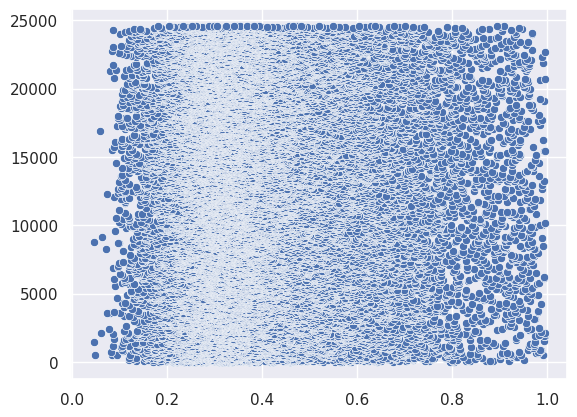

In [6]:
# Scatterplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()
sns.scatterplot(
    x = feature_proj_nullspace_norms.detach().cpu().numpy(),
    y = np.arange(24576)
)

In [7]:
(feature_proj_nullspace_norms > 0.95).sum()
select_mask = (feature_proj_nullspace_norms > 0.95)
select_idx = torch.where(select_mask)[0]
print(select_idx.shape)

torch.Size([165])


In [8]:
W_dec_selected = W_dec[select_idx]
print(W_dec_selected.shape)

torch.Size([165, 768])


In [9]:
# Compute pairwise cosine similarities
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(W_dec_selected.detach().cpu().numpy())
print(cosine_sim.shape)

(165, 165)


Text(0.5, 1.0, 'Trans-MLP-11 entropy features, pairwise W_dec cosine similarity')

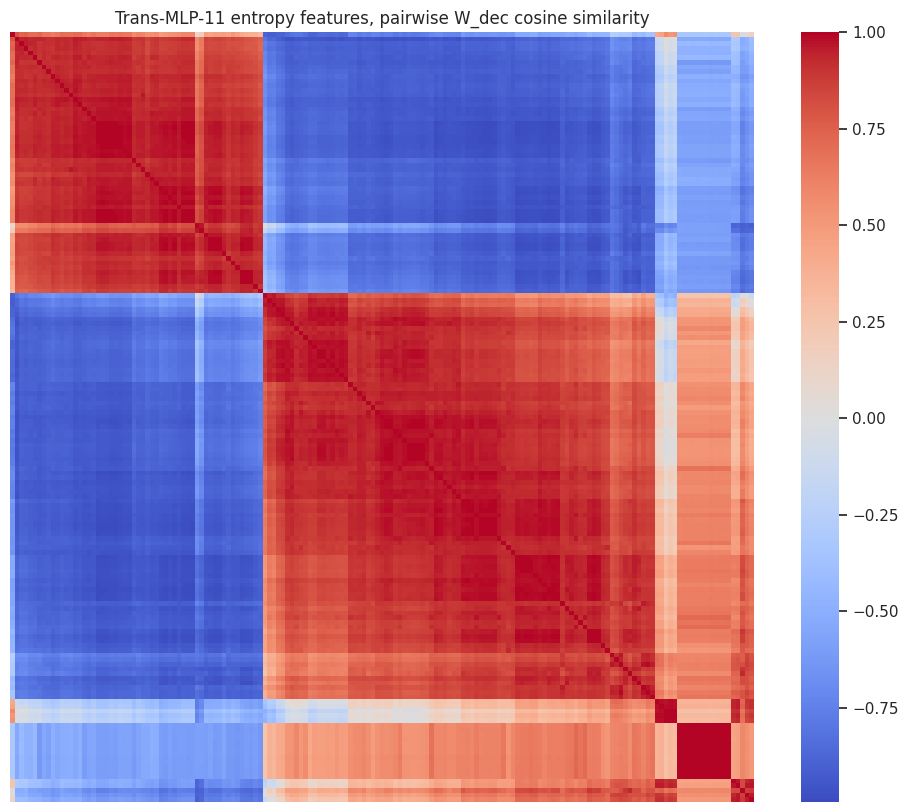

In [10]:
# Cluster by cosine sim and then plot heatmap
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

Z = linkage(1 - cosine_sim, method='ward')
# Get ordering
dendro = dendrogram(Z, no_plot=True)
order = dendro['leaves']

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    cosine_sim[order, :][:, order],
    xticklabels=False,
    yticklabels=False,
    cmap = 'coolwarm'
)
plt.title("Trans-MLP-11 entropy features, pairwise W_dec cosine similarity")


Text(0.5, 1.0, 'Trans-MLP-11 entropy features, pairwise W_enc cosine similarity')

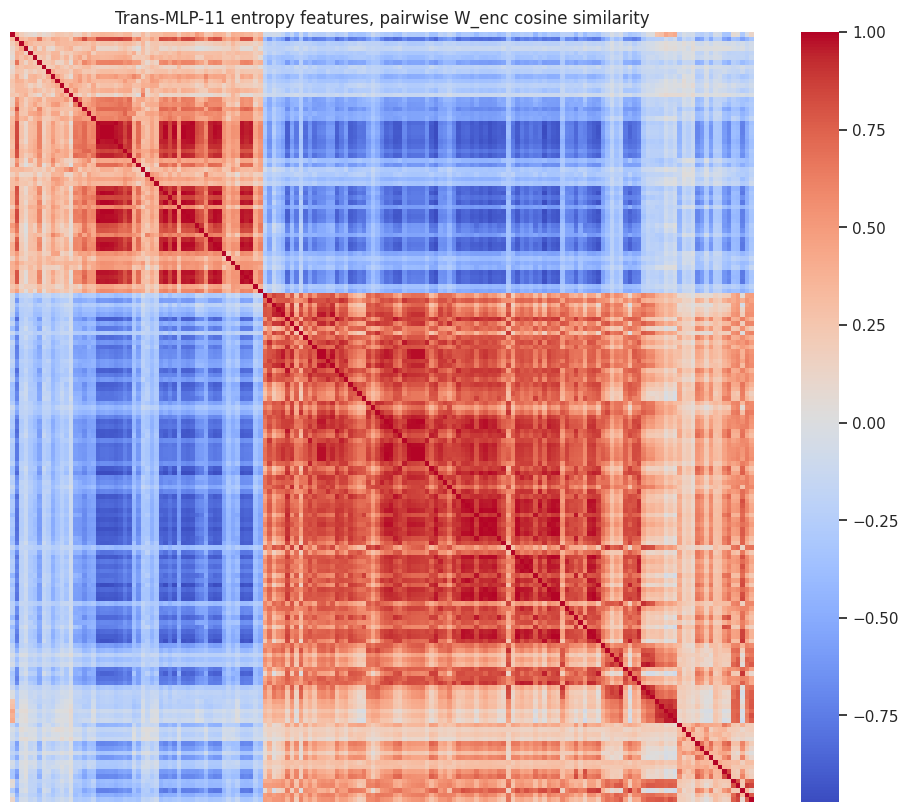

In [11]:
W_enc_selected = transcoder.W_enc[:, select_idx]
enc_cos_sims = cosine_similarity(W_enc_selected.T.detach().cpu().numpy())

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    enc_cos_sims[order, :][:, order],
    xticklabels=False,
    yticklabels=False,
    cmap = 'coolwarm'
)
plt.title("Trans-MLP-11 entropy features, pairwise W_enc cosine similarity")


In [12]:
from scipy.cluster.hierarchy import fcluster

num_clusters = 3
clusters = fcluster(Z, num_clusters, criterion='maxclust')
print(clusters)


[3 2 2 2 2 1 1 1 2 1 3 2 3 2 2 2 1 2 1 1 1 2 3 2 3 2 1 1 2 1 1 2 2 1 2 1 2
 2 1 3 1 2 1 2 2 2 2 1 2 1 2 2 3 1 2 1 2 2 1 3 2 1 1 1 1 2 2 2 1 2 2 2 2 3
 2 2 2 1 2 1 2 1 2 3 2 2 3 2 2 1 2 2 1 1 1 3 2 1 2 2 1 2 3 1 2 3 2 2 2 2 2
 2 2 2 1 2 1 2 1 1 1 1 2 1 2 2 1 2 2 2 2 3 1 2 1 3 2 3 2 1 1 2 3 2 2 1 3 2
 1 3 2 3 3 1 1 2 2 2 1 1 2 1 2 2 2]


In [13]:
cluster_idx = {
    i: [] for i in range(1, num_clusters + 1)
}
for idx, cluster_label in zip(select_idx, clusters):
    print(idx.item(), cluster_label)
    cluster_idx[cluster_label].append(idx.item())

127 3
499 2
680 2
685 2
730 2
848 1
849 1
894 1
1012 2
1144 1
1161 3
1199 2
1303 3
1329 2
1440 2
1515 2
1901 1
1902 2
1915 1
1978 1
2147 1
2165 2
2347 3
2399 2
2504 3
2510 2
2829 1
3112 1
3127 2
3389 1
3668 1
3722 2
3781 2
4240 1
4433 2
4687 1
4917 2
4937 2
4998 1
5171 3
5309 1
5341 2
5415 1
5707 2
5747 2
5750 2
5934 2
6132 1
6136 2
6186 1
6536 2
6565 2
6567 3
6720 1
7069 2
7121 1
7283 2
7328 2
7410 1
7642 3
7644 2
7724 1
7812 1
7969 1
8250 1
8260 2
8398 2
8457 2
8494 1
8607 2
8616 2
8770 2
9084 2
9147 3
9151 2
9424 2
9647 2
9880 1
9885 2
9994 1
10054 2
10143 1
10407 2
10507 3
10822 2
11193 2
11216 3
11419 2
11678 2
11761 1
11838 2
11847 2
11951 1
11968 1
12355 1
12410 3
12551 2
12661 1
12848 2
12953 2
12976 1
13068 2
13146 3
13270 1
13613 2
13870 3
13948 2
14003 2
14004 2
14246 2
14331 2
14445 2
14576 2
14800 2
15105 1
15417 2
15428 1
15690 2
16252 1
16775 1
17011 1
17219 1
17304 2
17622 1
17651 2
17663 2
17711 1
18044 2
18415 2
18555 2
18826 2
18831 3
19115 1
19262 2
19447 1
19464 3


In [18]:
import json
with open("cluster_idx.json", 'w') as jsonfile:
    json.dump(cluster_idx, jsonfile)

In [14]:
cluster_1_mean = W_dec[cluster_idx[1]].mean(dim=0)
torch.save(cluster_1_mean, 'cluster_1_mean.pt')

cluster_2_mean = W_dec[cluster_idx[2]].mean(dim=0)
torch.save(cluster_2_mean, 'cluster_2_mean.pt')

In [15]:
from circuit_finder.neuronpedia import get_neuronpedia_url_for_quick_list

get_neuronpedia_url_for_quick_list(
    layer = 11,
    features = cluster_idx[1][:10],
    sae_family = "tres-dc"
)

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%22848%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%22849%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%22894%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%221144%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%221901%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%221915%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%221978%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%

In [16]:
from circuit_finder.neuronpedia import get_neuronpedia_url_for_quick_list

url = get_neuronpedia_url_for_quick_list(
    layer = 11,
    features = cluster_idx[2][:20],
    sae_family = "tres-dc"
)
print(url)

https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%22499%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%22680%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%22685%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%22730%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%221012%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%221199%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%221329%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%22

In [17]:
from circuit_finder.neuronpedia import get_neuronpedia_url_for_quick_list

url = get_neuronpedia_url_for_quick_list(
    layer = 11,
    features = cluster_idx[3][:20],
    sae_family = "tres-dc"
)
print(url)

https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%22127%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%221161%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%221303%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%222347%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%222504%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%225171%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20%226567%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2211-tres-dc%22%2C%20%22index%22%3A%20